# Notebook for comparing different marginal likelihood estimators for VAEs as well as the performance of MH when using these estimators

## Initialization

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict
from math import ceil
import seaborn as sns

from approxmh.utilities import *
from approxmh.samplers import *
from approxmh.distributions import Banana, Funnel, create_gaussian_mixture, create_gaussian_lattice, create_random_gaussian_mixture, get_mode_coverage
from approxmh.distribution_metrics import *
from approxmh.sequential_mcmc import ULAKernel, run_annealed_importance_sampling, DensityMixture
from approxmh.vae import VAE, VAETrainer, get_filename
from approxmh.gan_latent_space_distributions import SNGANLatentSpace

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)


MODEL_DIR = '../models/'

def model_file(model, target_name):
    return MODEL_DIR + get_filename(model, target_name)

def save_model(model, target_name):
    model.save_knowledge(model_file(model, target_name))

def load_model(model, target_name):
    model.load_knowledge(model_file(model, target_name))

device: cuda


## Targets

In [37]:
def plot_target(N=4000, xlim=None, ylim=None, levels=30, dpi=30, proj_dims=(0, 1), plot_samples=True):
    fixed_coordinates = torch.zeros(D)

    fig, ax = plt.subplots(figsize=(5, 5))

    if plot_samples:
        # Implementation of torch.distributions.mixture_same_family.sample() causes MemoryOverflow without batched sampling
        target_sample = sample_by_batches(target, N, batch_size=1024)[:, proj_dims]
        ax.scatter(*pl(target_sample), zorder=4, alpha=0.5, s=150, edgecolors='none', marker='.')
        if xlim is None:
            xlim = (target_sample[:, 0].min().item(), target_sample[:, 0].max().item())
        if ylim is None:
            ylim = (target_sample[:, 1].min().item(), target_sample[:, 1].max().item())

    x = torch.linspace(*xlim, dpi)
    y = torch.linspace(*ylim, dpi)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    points = fixed_coordinates.repeat(dpi * dpi, 1)
    points[:, proj_dims[0]] = X.ravel()
    points[:, proj_dims[1]] = Y.ravel()
    Z = target.log_prob(points.to(device)).reshape(dpi, dpi)
    
    ax.contourf(to_numpy(X), to_numpy(Y), to_numpy(Z), levels=levels)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel(f'x_{proj_dims[0]}')
    ax.set_ylabel(f'x_{proj_dims[1]}')
    ax.set_title(f'{target_friendly_name} {" (Projection)" if D > 2 else ""}')

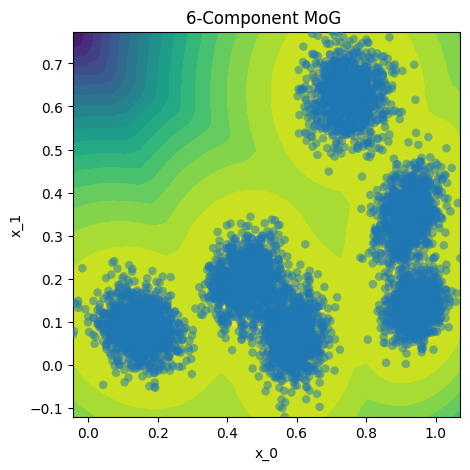

In [38]:
# Target 1
mean_lim = np.array([0, 1])
seed = 43
n_components = 6
D = 2
variance_lim = (0.001, 0.004)
target = create_random_gaussian_mixture(dim=D, n_components=n_components, mean_lim=mean_lim, variance_lim=variance_lim, device=device, seed=seed)
target_name = f'mog{n_components}_{D}d_vlim{variance_lim}_seed{seed}'
target_friendly_name = f'{n_components}-Component MoG'


plot_target(N=6_000, levels=20)
torch.cuda.empty_cache()

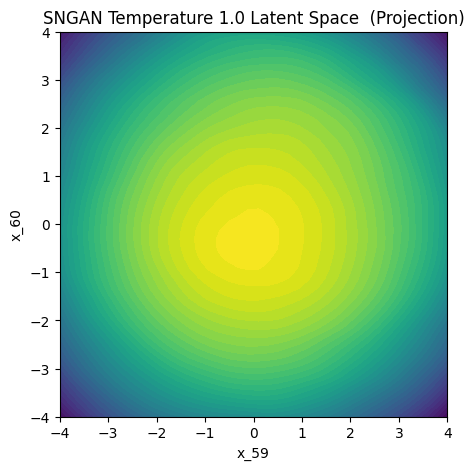

In [41]:
# Target 2
try:
    target = SNGANLatentSpace(device=device, temperature=1.0)
    D = target.latent_dim
    target_name = target.name()
    target_friendly_name = target.friendly_name()
    plot_target(N=1_000, xlim=(-4, 4), ylim=(-4, 4), levels=40, dpi=40, proj_dims=(59, 60), plot_samples=False)
except torch.cuda.OutOfMemoryError:
    print("Memory allocation failed")
    del target

torch.cuda.empty_cache()

## VAE Training/Loading

In [5]:
hidden_dims = (4, 4, 4, 4, 4)
vae = VAE(
    data_dim=D,
    hidden_dims=hidden_dims,
    latent_dim=D,
    device=device
)

# True -- train model, False -- load model from file
TRAIN_VAE = False

In [6]:
%%time

if TRAIN_VAE:
    x_train = target.sample((16_384,))
    print('VAE parameters:', count_parameters(vae))
    #optimizer = torch.optim.SGD(vae.parameters(), lr=0.05, momentum=0.9)
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.002)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=250)
    trainer = VAETrainer(
        vae, target, batch_size=2048, no_kl_penalty_epochs=10, kl_annealing_epochs=100, 
        warmup_period=2, optimizer=optimizer, scheduler=scheduler, device=device
    )
    trainer.fit(x_train, n_epochs=500, plot_interval=10)
    save_model(vae, target_name)
else:
    load_model(vae, target_name)

CPU times: total: 15.6 ms
Wall time: 28 ms


## Testing SMC Estimates

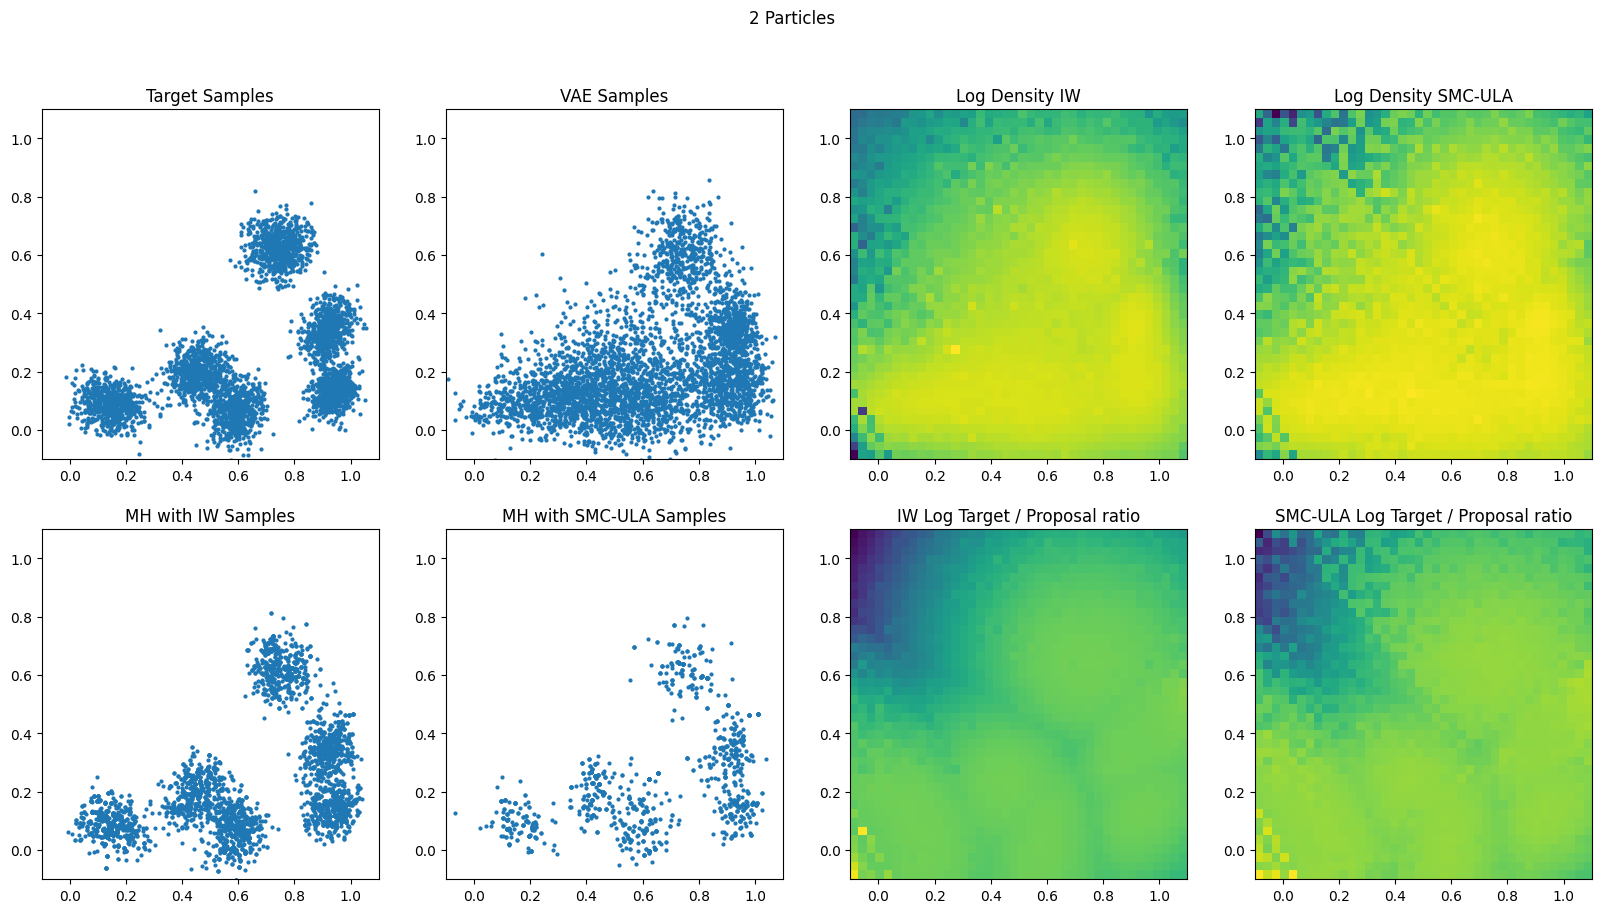

In [27]:
def compare_estimators_for_mh():
    # general parameters
    n_samples = 4000
    # SMC-ULA parameters
    n_particles = 2
    n_steps = 20
    ula_time_step = 0.002
    # plotting params
    xlim = (-0.1, 1.1)
    ylim = (-0.1, 1.1)
    d = 40
    x = np.linspace(*xlim, d)
    y = np.linspace(*ylim, d)
    X, Y = np.meshgrid(x, y)
    points = torch.tensor(np.vstack((X.ravel(), Y.ravel())).T, dtype=torch.float).to(device)

    vae_samples = vae.sample((n_samples,))
    cutoff = get_log_prob_quantile(target, q=0)
    
    marginal_estimators = [
        ('IW', lambda x : vae.iw_log_marginal_estimate(x, L=n_particles*n_steps, batch_L=64)),
        ('SMC-ULA', lambda x: vae.ais_ula_log_marginal_estimate(x, n_steps=n_steps, n_particles=n_particles, ula_time_step=ula_time_step))
    ]
    n_est = len(marginal_estimators)
    
    fig, axs = plt.subplots(ncols=2+n_est, nrows=2, figsize=(20,10))
    fig.suptitle(f'{n_particles} Particles')
    axs = axs.flatten()
    axs[0].set_title('Target Samples')
    axs[0].scatter(*pl(target.sample((n_samples,))), s=4)
    axs[1].set_title('VAE Samples')
    axs[1].scatter(*pl(vae_samples), s=4)
    for i, (estimator_name, estimator) in enumerate(marginal_estimators):
        ax = axs[2 + i]
        ax.set_title(f'Log Density {estimator_name}')
        estimated_logd = estimator(points).reshape(d, d)
        target_logd = target.log_prob(points).reshape(d, d)
        ax.imshow(to_numpy(estimated_logd), origin='lower', extent=[*xlim, *ylim], aspect="auto")

        ax = axs[2 + n_est + i]
        ax.set_title(f'MH with {estimator_name} Samples')
        # cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, vae_samples, cutoff, return_indicies=False)
        mh_acc_rate, mh_samples = metropolis_hastings_filter(target, vae_samples, estimator)
        ax.scatter(*pl(mh_samples), s=4)

        ax = axs[2 + 2 * n_est + i]
        ax.set_title(f'{estimator_name} Log Target / Proposal ratio')
        ax.imshow(to_numpy(target_logd - estimated_logd), origin='lower', extent=[*xlim, *ylim], aspect="auto")

    for ax in axs:
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)

compare_estimators_for_mh()

/home/doctor/venv/data/lib/python3.10/site-packages/approxmh/y_utils.py:61: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  return x.T.detach().cpu().numpy()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


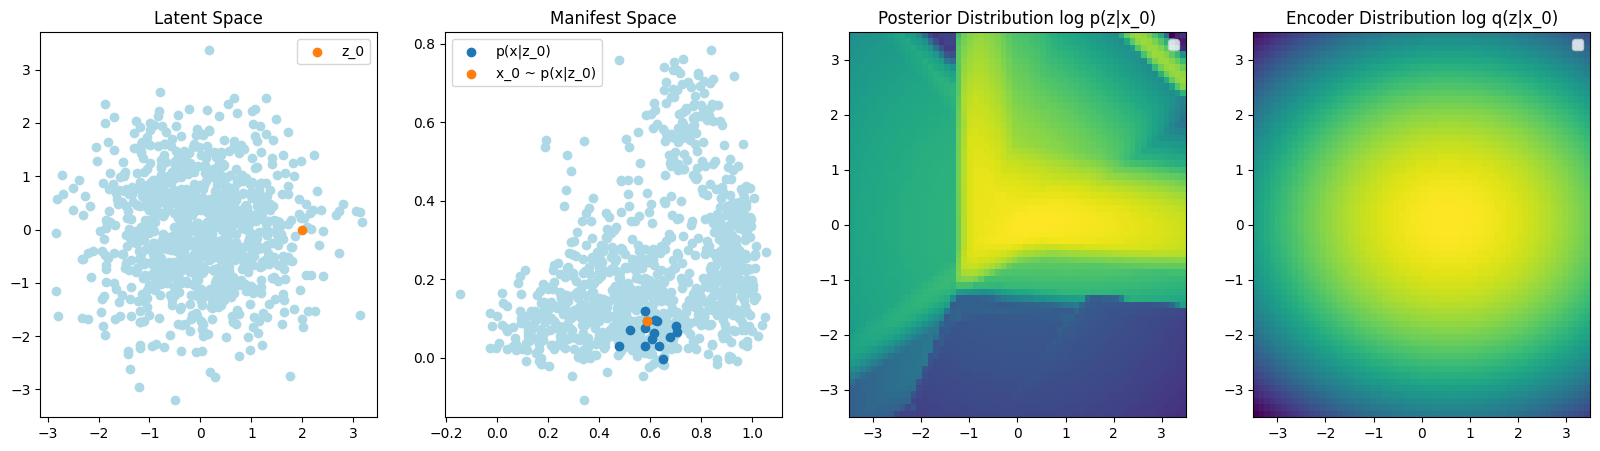

In [7]:
def one_point_analysis():
    n_samples = 1000
    n_dec = 15
    latent_xlim = (-3.5, 3.5)
    latent_ylim = latent_xlim
    dpi = 60
    
    # arbitrary point in latent space
    z_0 = torch.tensor([2., 0.], device=device)
    # sample from the decoder distribution
    decoder_distribution = vae.decoder_distribution(z_0.unsqueeze(0))
    xs = decoder_distribution.sample((n_dec,)).squeeze()
    x_0 = xs[:1]

    fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
    ax = axs[0]
    ax.set_title('Latent Space')
    ax.scatter(*pl(vae.prior.sample((n_samples,))), color='lightblue')
    ax.scatter(*pl(z_0), color='tab:orange', label='z_0')

    ax = axs[1]
    ax.set_title('Manifest Space')
    ax.scatter(*pl(vae.sample((n_samples,))), color='lightblue')
    ax.scatter(*pl(xs), label='p(x|z_0)')
    ax.scatter(*pl(x_0), label='x_0 ~ p(x|z_0)')
    # ax.scatter(*pl(vae.reconstruct(x_0.unsqueeze(0))), label='Reconstruction of x_0')

    ax = axs[2]
    ax.set_title('Posterior Distribution log p(z|x_0)')
    img = plot_2d_torch_function(ax, vae.posterior(x_0).log_prob, latent_xlim, latent_ylim, dpi, device=device)
    
    ax = axs[3]
    ax.set_title('Encoder Distribution log q(z|x_0)')
    img = plot_2d_torch_function(ax, vae.decoder_distribution(x_0).log_prob, latent_xlim, latent_ylim, dpi, device=device)

    for ax in axs:
        ax.legend()

one_point_analysis()

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [07:30<00:00,  2.25s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


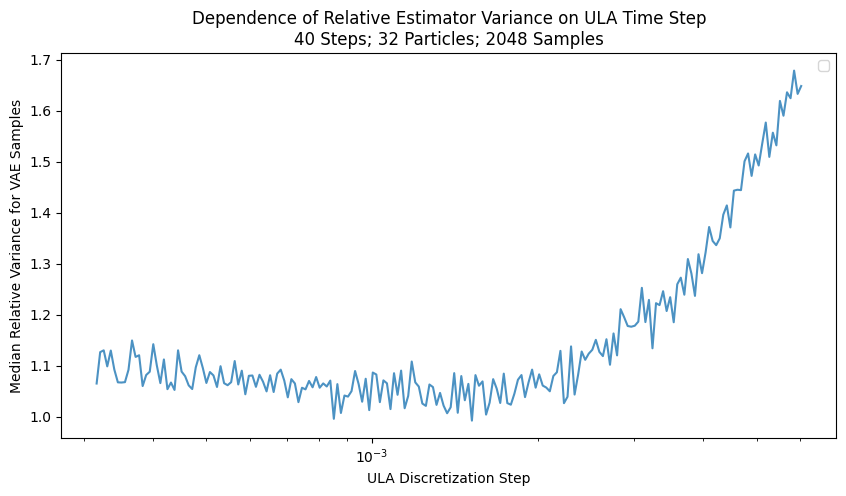

In [22]:
def vae_likelihood_estimation_variance_by_time_step():
    n_steps = 40
    n_particles = 32
    n_samples = 2048
    time_step_options = np.logspace(-3.5, -2.22, 200)  # ULA time step options

    vae_samples = vae.sample((n_samples,))

    iw_log_likelihoods, iw_variances = vae.iw_log_marginal_estimate(vae_samples, L=32_768, batch_L=4096, return_variance=True)
    iw_rel_variance = (iw_variances / iw_log_likelihoods.exp()).median().item()

    test_logs = defaultdict(list)
    for time_step in tqdm(time_step_options):
        log_likelihoods, variances = vae.ais_ula_log_marginal_estimate(vae_samples, n_steps, n_particles, time_step, True)
        test_logs['rel_variance'].append((variances / log_likelihoods.exp()).median().item())

    # rel_variances = torch.stack(test_logs['rel_variance'], dim=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(f'Dependence of Relative Estimator Variance on ULA Time Step\n{n_steps} Steps; {n_particles} Particles; {n_samples} Samples')
    ax.set_xlabel('ULA Discretization Step')
    ax.set_xscale('log')
    ax.set_ylabel('Median Relative Variance for VAE Samples')
    # ax.set_yscale('log')
    # ax.axhline(iw_rel_variance, label='IW Estimator Median Rel. Variance', color='black', linestyle='--')
    ax.plot(time_step_options, test_logs['rel_variance'], color='tab:blue', alpha=0.8)
    ax.legend()

vae_likelihood_estimation_variance_by_time_step()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:17<00:00,  2.75s/it]


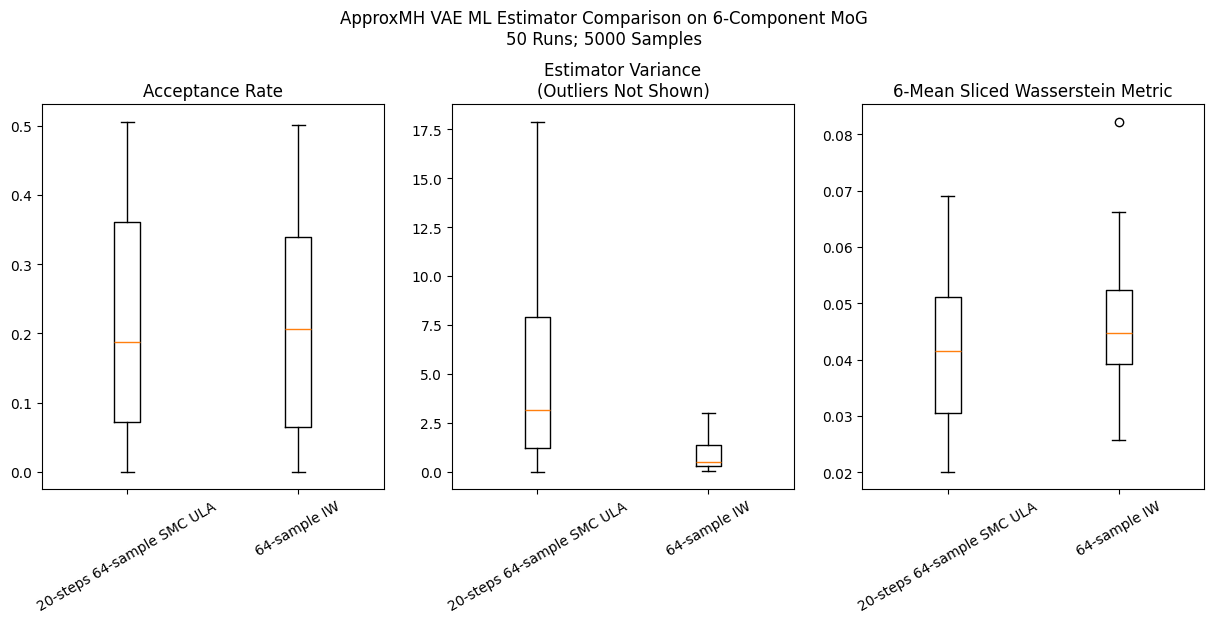

In [44]:
def compare_estimates():
    # Estimator 1
    n_steps = 20
    n_particles = 64
    time_step = 0.0015
    est1 = lambda x: vae.ais_ula_log_marginal_estimate(x, n_steps, n_particles, time_step, return_variance=True)
    est1_name = f'{n_steps}-steps {n_particles}-sample SMC ULA'
    # Estimator 2
    L = 64
    est2 = lambda x: vae.iw_log_marginal_estimate(x, L=L, batch_L=128, return_variance=True)
    est2_name = f'{L}-sample IW'

    estimators = [
        (est1, est1_name),
        (est2, est2_name)
    ]
    n_ests = len(estimators)
    
    # Comparison parameters
    n_runs = 50
    n_samples = 5000
    sample_metric = SlicedDistributionMetric(WassersteinMetric1d(), 3 * D)

    target_samples = target.sample((n_samples,))
    test_logs = [defaultdict(list) for _ in range(n_ests)]
    
    for run_i in tqdm(range(n_runs)):
        vae_samples = vae.sample((n_samples,))
        for i in range(n_ests):
            est, est_name = estimators[i]
            log_likelihoods, variances = est(vae_samples)
            test_logs[i]['rel_variances'].append(variances / log_likelihoods.exp())
            test_logs[i]['variances'].append(variances)
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, vae_samples, est)
            test_logs[i]['acc_rate'].append(mh_acc_rate)
            test_logs[i]['sample_metric'].append(sample_metric(target_samples, vae_samples).item())

    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

    ax = axs[0]
    ax.set_title('Acceptance Rate')
    ax.boxplot([test_logs[i]['acc_rate'] for i in range(n_ests)], labels=[est_name for est, est_name in estimators])

    ax = axs[1]
    ax.set_title('Estimator Variance\n(Outliers Not Shown)')
    ax.boxplot(
        [to_numpy(torch.cat(test_logs[i]['variances'])) for i in range(n_ests)], 
        labels=[est_name for est, est_name in estimators],
        showfliers=False
    )
    # ax.set_ylim(0., 10.)

    ax = axs[2]
    ax.set_title(sample_metric.name())
    ax.boxplot(
        [test_logs[i]['sample_metric'] for i in range(n_ests)], 
        labels=[est_name for est, est_name in estimators],
        showfliers=True
    )

    for ax in axs:
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    plt.suptitle(f'ApproxMH VAE ML Estimator Comparison on {target_friendly_name}\n{n_runs} Runs; {n_samples} Samples', y=1.07)

compare_estimates()